### Solving for a private mean age of a population

To solve for a private mean age of a population, we first:
1. get an estimate of the total age (by adding Laplace noise)
2. get an estimate of the total population (by adding Laplace noise)
3. divide the two estimates

We can do this with the `dp_mean()` function below, which also calls `laplace_mech()`.

In [1]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplace-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

def dp_mean(eps_n, eps_d, top, bot, top_sen=100.0, bot_sen=1.0):
  noisy_top = laplace_mech(top, eps_n, top_sen)
  noisy_bot = laplace_mech(bot, eps_d, bot_sen)
  return noisy_top / noisy_bot

def mse(true_answer, function_name, *params):
  """true_answer is either a scalar or numpy array"""
  niterations = 100_000
  return sum(np.sum((true_answer - function_name(*params))**2) for x in range(niterations)) / float(niterations)

Let's start by importing the necessary libraries and loading the PUMS data.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pa = pd.read_csv("psam_p22.csv")

Next, let's query the population we want to calculate the mean age of: people in PUMA 2400 who migrated from another PUMA.

In [4]:
def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1

pa['MIGRATED']=pa.MIGPUMA.apply(migrecode)

pa = pa.query('PUMA==2400 and MIGRATED==1')

Now, let's calculate the values we need for `dp_mean()`. These include `total_age`, `total_population`, `age_sensitivity`, and `population_sensitivity`.

In [5]:
total_age = pa.AGEP.sum()
total_population = float(pa.AGEP.size)
age_sensitivity = 99-0
population_sensitivity = 1.0

We also need to consider our privacy budget, `eps`. We can take `eps` and split it into two pieces: one for estimating the numerator (`eps_n`) and another for estimating the denominator (`eps_d`), so that `eps = eps_n + eps_d`.

The choice of `eps_n` and `eps_d` clearly affects accuracy. A researcher can plug in different splits of `eps_n` and `eps_d` to see how low they can make the estimated mse. However, to be technically differentially private, this analysis of splits should not be done on the confidential data to which noise is being added. It would have to be done to dummy data.

In [7]:
eps_n = 0.25
eps_d = 0.25
assert eps_n + eps_d <= 1.0000000001, "eps_n + eps_d must be at most 1"

We can test these values and their accuracy with the `dp_mean()` and `mse()` functions, like below. In this example, we use an epsilon of .5 for the mean, with .25 allocated to privacy loss in the numerator and .25 allocated to privacy loss in the denominator. 

In this case, differential privacy doesn't change the mean age much, even with a small epsilon, because adding or removing one person from the dataset can change the count by at most 1 and the total by at most 99, since that is the topcode for age in this dataset. If we were using a variable like the internal version of income that is topcoded at a very high value the sensitivity would be higher, and we would have to add more noise.

In [11]:
raw_mean=pa.mean()
print("The raw mean is ",raw_mean['AGEP'])
#raw_sum=pa.sum()
#print(raw_sum)

noisy_mean = dp_mean(eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
error = mse(total_age/total_population, dp_mean, eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
print("A noisy mean is ", noisy_mean)
print("mse is ", error)

The raw mean is  32.5872518286
A noisy mean is  32.54988862671942
mse is  0.377563165269


We want to be able to calculate the `noisy_mean` for different values of epsilon and calculate the average accuracy of the `noisy_mean` for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

In [9]:
def avg_l1_mean(true_mean, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_mean = dp_mean(eps/2, eps/2, total_age, total_population, age_sensitivity, population_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_mean-true_mean], 1)/(2*1))
        total += accuracy
    return total/n

Let's use `avg_l1_mean()` to calculate the average accuracy of the noisy mean over a range of epsilon values and visualize the output.

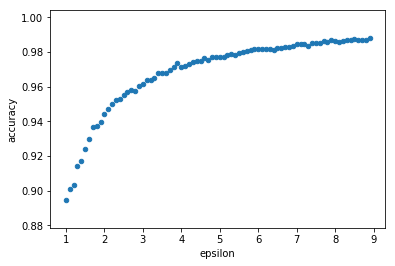

In [10]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,9.0,.1))
accuracy_df['epsilon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_mean(total_age/total_population, x) for x in eps_range]
accuracy_df.plot.scatter('epsilon', 'accuracy')
plt.show()

### Solving for a private median age of a population

The median is more of a pain to calculate because the sensitivity is high. The sensitivity of the median is half of the difference between the maximum and minimum possible values of the variable.


In [97]:
true_median = pa.AGEP.median()

In this case, the age sensitivity is 99/2, since age is topcoded at 99 in this dataset. Your dataset may topcode age at some different value or may not topcode age.

In [95]:
age_sensitivity = (99-0)/2

In [96]:
print("True Median: ",true_median)

print("Noisy Median: ",laplace_mech(true_median,epsilon=3,sensitivity=99/2))

True Median:  30.0
Noisy Median:  48.98819613481358


We can now use `age_sensitivity` and `laplace_mech()` to calculate the `noisy_median`. We want to do this for different values of epsilon, and be able to calculate the average accuracy of the `noisy_median` for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

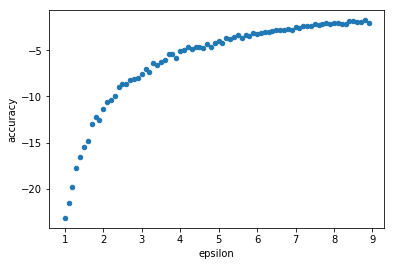

In [98]:
def avg_l1_median(true_median, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_median = laplace_mech(true_median, eps, age_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_median-true_median], 1)/(2*1))
        total += accuracy
    return total/n

accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,9.0,.1))
accuracy_df['epsilon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_median(true_median, x) for x in eps_range]
accuracy_df.plot.scatter('epsilon', 'accuracy')
plt.show()

There is another formulation of differential privacy that includes medians, but we have not yet implemented a feasible differentially private solution. Several projects have been approved with non-differentially private methods.